# TO DO
1. Figure out dataset
2. Break down into individual characters
3. Form corpus from dataset for input and output characters
4. Assign a number to each character
5. Model will have an embedding so it will handle it
6. Output will be a bunch of integers so we will have to decode it

In [ ]:
!pip install wandb
# !pip install tensorflow
# !pip install keras

In [ ]:
import tarfile
import os
import pandas as pd
import keras
import numpy as np
# import wandb
import tensorflow as tf
import shutil
from keras import layers
from keras.layers import LSTM, Dense, Embedding, Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
from tqdm.auto import tqdm
from keras.layers import Lambda
from keras import backend as K
import datetime

from sklearn.utils import shuffle

In [ ]:
!wget -nc https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

if not os.path.isdir('/content/dakshina_dataset_v1.0'):
  tarfile.open("/content/dakshina_dataset_v1.0.tar").extractall()

--2021-05-10 14:56:28--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   130MB/s    in 24s     

2021-05-10 14:56:53 (78.9 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
wandb.login(key='14394907543f59ea21931529e34b4d80d2ca8c9c')

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Loading Data

In [ ]:
class data_loader():

  @staticmethod
  def _load_raw_df(languages = ["mr","hi"]):
    lex = dict()
    lex['train'], lex['val'], lex['test'] = [], [], [] 
    column_names = ['output', 'input', 'count']
    
    for la in languages:
      lex['train'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.train.tsv', sep='\t', header=None, names=column_names))
      lex['val'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.dev.tsv', sep='\t', header=None, names=column_names))
      lex['test'].append(pd.read_csv('/content/dakshina_dataset_v1.0/'+la+'/lexicons/'+la+'.translit.sampled.test.tsv', sep='\t', header=None, names=column_names))

    lex['train'] = pd.concat(lex['train'])
    lex['val'] = pd.concat(lex['val'])
    lex['test'] = pd.concat(lex['test'])

    return lex    

  @staticmethod
  def _make_final_df(lex):
    
    for div in ['train', 'val', 'test']:
    
      # removing non max transliterations
      idx = lex[div].groupby(['input'])['count'].transform(max) == lex[div]['count']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # calclulating difference in lengths of various transliterations
      lex[div]['input_len'] = lex[div].apply(lambda x: len(str(x['input'])), axis=1)
      lex[div]['output_len'] = lex[div].apply(lambda y: len(str(y['output'])), axis=1)
      lex[div]['mod_dif'] = lex[div].apply(lambda z: abs(z['input_len'] - z['output_len']), axis=1) 

      # removing transliterations that vary by a lot in length
      idx = lex[div].groupby(['input'])['mod_dif'].transform(min) == lex[div]['mod_dif']
      lex[div] = lex[div][idx].reset_index(drop=True)

      # removing duplicates if any remain
      lex[div].drop_duplicates(subset='input', keep='first', inplace=True)

      # removing redundant columns
      lex[div].drop(labels=['count', 'input_len', 'output_len', 'mod_dif'], inplace=True, axis=1)

      # shuffling the dataset i.e. rows of the dataset
      lex[div] = lex[div].sample(frac=1)

    return lex

  @staticmethod
  def _generate_batch(X, y, data_dict, num_decoder_tokens, batch_size = 1):

    while True:
        for j in range(0, len(X), batch_size):
            
            # placeholder data structures
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, data_dict['max_target_length']),dtype='float32')
            decoder_target_data = np.zeros((batch_size, data_dict['max_target_length'], num_decoder_tokens),dtype='float32')

            # assessing one batch at a time
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):

                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t<len(target_text)-1:
                        # decoder input sequence
                        # does not include the <EOW> token
                        decoder_input_data[i, t] = word 
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the <SOW> token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

  @staticmethod
  def _generate_batch_greedy(X, y, data_dict, num_decoder_tokens, batch_size = 1):

    while True:
        for j in range(0, len(X), batch_size):

            # placeholder data structures
            encoder_input_data = np.zeros((batch_size, data_dict['max_source_length']),dtype='float32')
            decoder_input_data = np.zeros((batch_size, 1),dtype='float32')
            decoder_target_data = np.zeros((batch_size, 23, num_decoder_tokens),dtype='float32')
            
            # assessing one batch at a time
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text):
                  encoder_input_data[i, t] = word
                for t, word in enumerate(target_text):
                    if t==0 :
                        decoder_input_data[i, t] = 1 # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        #print(word)
                        decoder_target_data[i, t - 1, word] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
class Tokenizer:

  def __init__(self, df):

    self.start_token = '<SOW>'
    self.stop_token = '<EOW>'
    self.unknown_token = '<UNK>'

    self.input_corpus = [self.start_token, self.stop_token, self.unknown_token]
    self.output_corpus = [self.start_token, self.stop_token, self.unknown_token]

    input_words = df.input.tolist()
    output_words = df.output.tolist()

    for word in input_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.input_corpus:
          self.input_corpus.append(token)

    for word in output_words:
      tokens = str(word)
      for token in tokens:
        if token not in self.output_corpus:
          self.output_corpus.append(token)
    
    self.encode_dict_input = {self.input_corpus[i] : i+1 for i in range(len(self.input_corpus))}
    self.decode_dict_input = {k:v for v,k in self.encode_dict_input.items()}
    
    
    self.encode_dict_output = {self.output_corpus[i] : i+1 for i in range(len(self.output_corpus))}
    self.decode_dict_output = {k:v for v,k in self.encode_dict_output.items()}
    ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ????? 
    self.decode_dict_output.update({2:''})

  # takes in lists of words and returns lists of integers
  def encode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for word in X:
        word = str(word)
        integer_list =np.array([self.encode_dict_input.get(token, self.encode_dict_input[self.unknown_token]) for token in word])
        input_list.append(integer_list)
      
      return input_list
    
    if (mode=='output'):
      output_list = []
      for word in X:
        word = str(word)
        integer_list = np.array([self.encode_dict_output[self.start_token]] + [self.encode_dict_output.get(token, self.encode_dict_output[self.unknown_token]) for token in word] + [self.encode_dict_output[self.stop_token]])
        output_list.append(integer_list)
      
      return output_list
    

  # takes in lists of integers and returns lists of words
  def decode(self, X, mode='input'):

    if (mode=='input'):
      input_list = []
      for integers in X:
        token_list = [self.decode_dict_input.get(integer, '') for integer in integers] 
        input_list.append(''.join(token_list))
      
      return input_list

    if (mode=='output'):
      output_list = []
      for integers in X:
        token_list = [self.decode_dict_output.get(integer, '') for integer in integers[1:-1]] 
        output_list.append(''.join(token_list))
      
      return output_list

In [ ]:
def return_data_dict(languages=['mr','hi'], batch_size=32):

  lex = data_loader._load_raw_df(languages)
  lex = data_loader._make_final_df(lex)

  data_dict = dict()

  df_train = lex['train']
  df_val = lex['val']
  df_test = lex['test']

  tk = Tokenizer(df_train)

  ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ????? 
  data_dict['in_size'] = len(tk.input_corpus) + 1
  data_dict['out_size'] = len(tk.output_corpus) + 1

  X_train = tk.encode(df_train.input.tolist(), mode='input')
  Y_train = tk.encode(df_train.output.tolist(), mode='output')
  
  X_val = tk.encode(df_val.input.tolist(), mode='input')
  Y_val = tk.encode(df_val.output.tolist(), mode='output')
  
  X_test = tk.encode(df_test.input.tolist(), mode='input')
  Y_test = tk.encode(df_test.output.tolist(), mode='output')


  data_dict['train'], data_dict['val'], data_dict['test']= dict(), dict(), dict()


  data_dict['train']['df'] = df_train
  data_dict['val']['df'] = df_val
  data_dict['test']['df'] = df_test


  data_dict['train']['max_source_length'] = np.max(np.array([len(x) for x in X_train]))
  data_dict['train']['max_target_length'] = np.max(np.array([len(x) for x in Y_train]))
  
  data_dict['val']['max_source_length'] = np.max(np.array([len(x) for x in X_val]))
  data_dict['val']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))
  
  data_dict['test']['max_source_length'] = np.max(np.array([len(x) for x in X_test]))
  data_dict['test']['max_target_length'] = np.max(np.array([len(x) for x in Y_test]))


  data_dict['max_source_length'] = max(data_dict['train']['max_source_length'], data_dict['val']['max_source_length'], data_dict['test']['max_source_length'])
  data_dict['max_target_length'] = max(data_dict['train']['max_target_length'], data_dict['val']['max_target_length'], data_dict['test']['max_target_length'])


  data_dict['train']['batch'] = data_loader._generate_batch(X_train, Y_train, data_dict['train'], data_dict['out_size'], batch_size)
  data_dict['train']['batch_greedy'] = data_loader._generate_batch_greedy(X_train, Y_train, data_dict['train'], data_dict['out_size'], batch_size)
  
  data_dict['val']['batch'] = data_loader._generate_batch(X_val, Y_val, data_dict['val'], data_dict['out_size'], batch_size)
  data_dict['val']['batch_greedy'] = data_loader._generate_batch_greedy(X_val, Y_val, data_dict['val'], data_dict['out_size'], batch_size)

  data_dict['test']['batch'] = data_loader._generate_batch(X_test, Y_test, data_dict['test'], data_dict['out_size'], batch_size)  
  data_dict['test']['batch_greedy'] = data_loader._generate_batch_greedy(X_test, Y_test, data_dict['test'], data_dict['out_size'], batch_size)    
  data_dict['test']['batch_1'] = data_loader._generate_batch_greedy(X_test, Y_test, data_dict['test'], data_dict['out_size'], 1)


  data_dict['tokenizer'] = tk

  return data_dict

In [ ]:
data_dict = return_data_dict()

In [ ]:
# data = dict()
# data['train'] = dict()
# data['train']['X'] = X_train
# data['train']['Y'] = Y_train
# data['in_size'] = len(tk.input_corpus) + 1
# data['out_size'] = len(tk.output_corpus) + 1
# num_decoder_tokens = data['out_size'] 
# max_source_length = np.max(np.array([len(x) for x in X_train]))
# max_target_length = np.max(np.array([len(x) for x in Y_train]))

# Question 1


In [ ]:
class BeamSearchCallBack(keras.callbacks.Callback):
  def __init__(self, details, test_data, tokenizer, out_size, num_val=200, beam=3) :
    self.details = details
    self.test_data = test_data
    self.tokenizer = tokenizer
    self.out_size = out_size
    self.num_val = num_val
    self.beam = beam

  def on_epoch_end(self, epoch, logs=None) :
    
    # defining the encoder model
    encoder_model = Model(self.details['encoder_inputs'], self.details['encoder_states'])
    
    # hidden representation size
    rep_size = self.details['params']['rep_size']

    # initializing decoder state input
    decoder_state_input = []

    
    for i in range(len(self.details['encoder_states'])) :
        new_state = Input(shape=(rep_size,))
        decoder_state_input.append(new_state)
    decoder_inputs = self.details['decoder_inputs']
    x = self.details['decoder_embedding'](decoder_inputs)
    
    for layer in self.details['decoder_layers'] :
      x, *decoder_states = layer(x,initial_state=decoder_state_input)

    x = self.details['decoder_dense'](x)
    decoder_model = Model(
        [decoder_inputs] + decoder_state_input,
        [x] + decoder_states )
    inp = self.tokenizer.encode(self.test_data['df'].input.tolist())
    out = self.tokenizer.encode(self.test_data['df'].output.tolist(),mode='output')
    out_size = self.out_size
    val_gen = data_loader._generate_batch(inp,out,self.test_data,self.out_size)
    acc = 0
    for i in tqdm(range(self.num_val)) :
      (input_seq,ans) , _ = next(val_gen)
      _,best = decode_sequence_beam(input_seq,self.beam,encoder_model,decoder_model,self.tokenizer,self.test_data['max_target_length'])
      w1 = self.tokenizer.decode(best,mode='output')
      w2 = self.tokenizer.decode(ans,mode='output')
      comp = (w1==w2)
      if comp :
        acc += 1    

    acc /= len(inp)
    print("Val Accuracy : "+str(acc))
    

In [ ]:
def decode_sequence_beam(input_seq, k, encoder_model, decoder_model, tk, max_target_length=20, getall=False):
    # encode the input as state vectors
    states_value = encoder_model.predict(input_seq,batch_size=1,use_multiprocessing=True)
    # generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # populate the first character of target sequence with the start character.
    target_seq[0, 0] = 1 
    run_condition = [True for i in range(k)]
    # print(len(states_value))
    # print([target_seq] + [states_value])
    results, *states_values_temp = decoder_model.predict([target_seq] + [states_value])
    output_tokens = results

    states_values_k = [states_values_temp for i in range(k)]
    #get topk indices
    ind = np.argpartition(np.array(output_tokens[0, -1, :]), -k)[-k:]
    bestk_ind = ind
    output_tokens = np.array(output_tokens[0, -1, :])
    bestk_prob = output_tokens[ind]
    bestk_tot = [[1,bestk_ind[i]] for i in range(k)]
    # print(bestk_tot)

    
    while any(run_condition):
        bestk_tot_new = []
        bestk_prob_new = []
        states_values_k_new = []
        for i in range(k) :
            if run_condition[i] :
                a = bestk_tot[i]
                b = bestk_prob[i]
                target_seq[0,0] = a[-1]
                results,*states_values_temp = decoder_model.predict([target_seq] + states_values_k[i],batch_size=1)
                output_tokens = results

                states_values_k_temp = [states_values_temp for m in range(k)]

                states_values_k_new += states_values_k_temp
                ind = np.argpartition(np.array(output_tokens[0, -1, :]), -k)[-k:]
                bestk_ind = ind
                output_tokens = np.array(output_tokens[0, -1, :])
                bestk_prob_temp = output_tokens[ind]
                bestk_tot_temp = [a+[bestk_ind[j]] for j in range(k)]
                bestk_prob_temp2 = [b*bestk_prob_temp[j] for j in range(k)]
                bestk_prob_new += bestk_prob_temp2
                bestk_tot_new += bestk_tot_temp
            
            else :
                a = bestk_tot[i]
                b = bestk_prob[i]
                bestk_tot_new += [bestk_tot[i]]
                bestk_prob_new += [b]
                states_values_k_new += [states_values_k[i]]

        bestk_prob_new = np.array(bestk_prob_new)
        # print(len(bestk_prob_new),len(bestk_tot_new),len(states_values_k_new))
        ind = np.argpartition(bestk_prob_new,-k)[-k:]
        bestk_tot = [bestk_tot_new[i] for i in ind]
        states_values_k = [states_values_k_new[i] for i in ind]
        bestk_prob = bestk_prob_new[ind]
        run_condition = []
        for i in range(k) :
            a = bestk_tot[i]
            b = bestk_prob[i]
            if a[-1]!= 2 and len(a)<=max_target_length :
              run_condition.append(True)
            else :
              run_condition.append(False)

        # print(bestk_tot)

    final_words = []
    best_word = []
    best = 0.0
    for i in range(k) :
      a = bestk_tot[i]
      b = bestk_prob[i]
      final_words += [a]
      if b > best :
        best_word = [a]

    if getall :
      return (tk.decode(final_words,'output'),best_word)
    else :
      return final_words,best_word

In [ ]:
class rnn():

  def __init__(self, params,attn=False ):
    
    num_encode_layers = params['num_encode_layers']
    num_decode_layers = params['num_decode_layers']
    data_dict = params['data_dict']
    in_size = params['data_dict']['in_size']
    out_size = params['data_dict']['out_size']
    cell_type = params['cell_type']
    dropout = params['dropout']
    embed_size = params['embed_size']
    rep_size = params['rep_size']
        
    ###################### ENCODER NETWORK ######################
    
    encoder_inputs = Input(shape=(None,))
    x = Embedding(in_size, embed_size ,mask_zero=True)(encoder_inputs)

    encoder_layers = []
    
    for j in range(num_encode_layers-1) :   
      curr_layer = getattr(layers, cell_type)(rep_size, dropout=dropout, return_sequences=True)
      encoder_layers.append(curr_layer)
      x = curr_layer(x)

    curr_layer = getattr(layers, cell_type)(rep_size, dropout=dropout, return_state=True)
    encoder_layers.append(curr_layer)
    x, *encoder_states = curr_layer(x)

    ###################### DECODER NETWORK ######################

    decoder_inputs = Input(shape=(None,))

    decoder_embedding =  Embedding(out_size, embed_size, mask_zero=True)
    x = decoder_embedding(decoder_inputs)

    if attn :
      decoder_attn = Attention()
      a = decoder_attn(x)
    decoder_layers = []    
    
    for j in range(num_decode_layers) :
      curr_layer = getattr(layers, cell_type)(rep_size,dropout=dropout,return_state=True, return_sequences=True)
      decoder_layers.append(curr_layer)
      x, *decoder_states = curr_layer(x, initial_state=encoder_states)

    decoder_dense = Dense(units=out_size, activation='softmax')
    decoder_outputs = decoder_dense(x)

    # define the model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ????? 
    self.model = model
    self.encoder_inputs = encoder_inputs
    self.encoder_layers = encoder_layers
    self.decoder_inputs = decoder_inputs
    self.decoder_embedding = decoder_embedding
    self.decoder_layers = decoder_layers
    self.decoder_dense = decoder_dense
    self.encoder_states = encoder_states
    self.params = params
    self.decoder_attn = decoder_attn
    self.attn = attn
    self.details = {
        'model' : self.model,
        'encoder_inputs' : self.encoder_inputs,
        'encoder_layers' :self.encoder_layers ,
        'decoder_inputs' :self.decoder_inputs ,
        'decoder_embedding' : self.decoder_embedding,
        'decoder_layers' : self.decoder_layers,
        'decoder_dense' : self.decoder_dense,
        'encoder_states' : self.encoder_states ,
        'params' :self.params,
        'attn' : self.attn,
        'decoder_attn' : decoder_attn
    }

  def compile_and_fit(self, data_dict, params):

    # compiling the model
    self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    # printing the summary of the model
    summary = self.model.summary()

    # plotting the model figure
    plot = plot_model(self.model, show_shapes=True)
    
    # total training samples
    train_samples = len(data_dict['train']['df'])

    # total validation samples
    val_samples = len(data_dict['val']['df'])    
    
    # batch size
    batch_size = params['batch_size']

    # number of epochs
    num_epochs = params['num_epochs']

    # training the model
    run_details = self.model.fit_generator(generator = data_dict['train']['batch'],
                                           ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
                                           steps_per_epoch = train_samples//batch_size,
                                           epochs=num_epochs,
                                           # callbacks=[
                                           # BeamSearchCallBack(self.details,data_dict['val'],data_dict['tokenizer'],data_dict['out_size'],num_val=num_val_samples,beam=beam),
                                                        # wandb.keras.WandbCallback()
                                                        # ],
                                           validation_data = data_dict['val']['batch'],
                                           ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ????? 
                                           validation_steps = val_samples//batch_size
                                          )

    return {
        'run_details' : run_details
    }



In [ ]:
class rnn_second() :
  def __init__(self, details) :

    # copying required details
    self.details = details

    # copying decoder state input
    decoder_state_input = self.details['encoder_states']

    ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
    decoder_inputs = Input(shape=(1,))

    # copying hidden representation size
    rep_size = self.details['params']['rep_size']

    # copying decoder inputs
    decoder_inputs = self.details['decoder_inputs']

    # the decoder model
    x = self.details['decoder_embedding'](decoder_inputs)
    if details['attn'] :
      x = self.details['decoder_attn'](x)
  
    all_outputs = []
    for _ in range(self.details['params']['data_dict']['max_target_length']) :
        for layer in self.details['decoder_layers'] :
            x, *decoder_states = layer(x, initial_state=decoder_state_input)

        x = self.details['decoder_dense'](x)

        # appending the softmax output
        all_outputs.append(x)

        # taking the argmax to feed into the next time step
        x = tf.math.argmax(x,2)  
        x = self.details['decoder_embedding'](x)
        if details['attn'] :
          x = self.details['decoder_attn'](x)
        
        # decoder state input for the next time step
        decoder_state_input = decoder_states

    ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
    # where do we evaluate stop condition?

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model([self.details['encoder_inputs'], decoder_inputs], decoder_outputs)
    self.model = model

  def compile_and_fit(self,data_dict,params) :

    # compiling the model
    self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

     # printing the summary of the model   
    summary = self.model.summary()

    # plotting the model figure
    plot = plot_model(self.model, show_shapes=True)
    
    # total training samples
    train_samples = len(data_dict['train']['df'])

    # total validation samples 
    val_samples = len(data_dict['val']['df'])

    # batch size   
    batch_size = params['batch_size']

    # number of epochs
    num_epochs = params['num_epochs_2']

    # training the model
    run_details = self.model.fit_generator(generator = data_dict['train']['batch_greedy'],
                                            steps_per_epoch = train_samples//batch_size,
                                            epochs=num_epochs)
                                            # callbacks=[
                                                      # BeamSearchCallBack(self.details,data_dict['val'],data_dict['tokenizer'],data_dict['out_size'],num_val=num_val_samples,beam=beam),
                                                      # wandb.keras.WandbCallback()
                                                      # ],
                                            # validation_data = data_dict['val']['batch_greedy'],
                                            # validation_steps = val_samples//batch_size)
   
    return {
        'run_details' : run_details
    }

  def evaluate(self, data_dict) :

    # test batch generator
    test_gen = data_dict['test']['batch_greedy']
    
    # number of test samples
    test_samples = len(data_dict['test']['df'])
    
    ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
    batch_size=32

    num_hits = 0
    
    for _ in range(test_samples//batch_size) :
      (a,b),c = next(test_gen)
      l1 = data_dict['tokenizer'].decode(np.argmax(c, axis=2), mode='output')
      out = self.model.predict([a,b])
      out = np.argmax(out,axis=2)
      l2 = data_dict['tokenizer'].decode(out, mode='output')
      num_hits += np.sum(np.array(l1)==np.array(l2))
    
    ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
    print("Test Acc ",acc/test_samples)
    wandb.log({"Final Test Accuracy" : acc/test_samples})

In [ ]:
class tools:
  def init_params(config,data_dict):
  
    # returning parameters
    params = {
        'num_encode_layers' : config.num_encode_layers,
        'num_decode_layers' : config.num_decode_layers,
        'cell_type' : config.cell_type,
        'rep_size' : config.rep_size,
        'embed_size' : config.embed_size,
        'dropout' : config.dropout,
        'num_epochs' : config.num_epochs,
        'num_epochs_2' : config.num_epochs_2,
        'data_dict' : data_dict,
        'batch_size' : config.batch_size
    }
    return params

In [ ]:
# sweep configuration
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_acc',
        'goal' : 'maximize'
    },
    'parameters': {
        'cell_type' : {
            'values': ['LSTM', 'GRU', 'SimpleRNN']  
        },
        'embed_size': {
            'values': [10]
        },
        'rep_size': {
            'values': [32, 64, 128, 256]
        },
        'dropout': {
            'values': [0, 0.2, 0.4]
        },
        'batch_size': {
            'values': [32]
        },
        'num_epochs': {
            'values': [25]
        },
        'num_epochs_2' : {
            'values': [25]
        },
        'num_encode_layers': {
            'values': [1, 2, 4]
        },
        'num_decode_layers': {
            'values': [1, 2, 4]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='dakshina_v2')

Create sweep with ID: 0ztbl62r
Sweep URL: https://wandb.ai/ramkamal/dakshina_v2/sweeps/0ztbl62r


In [ ]:
class sweep_module:
  @staticmethod
  def train(config=None):

    with wandb.init(config):
      
      # copying the config 
      config = wandb.config
 
      # naming the run
      # wandb.run.name = 'fil:'+str(config['num_filters_'])+'_type:'+config['type_of_filters'][0]+'_aug:'+str(config['augmentation'])[0]+'_dro:'+str(config['dropout'])[0]
      wandb.run.name = 'typ:'+config['cell_type'][:4]+ '_' + 'emb:'+str(config['emdbed_size'])+ '_' + 'enc:' + str(config['num_encode_layers'])+ '_' + 'dec:'+str(config['num_decode_layers'])
      
      # returning the data dictionairy
      ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
      data_dict = return_data_dict(batch_size=config.batch_size)

      # copying the parameters
      params = tools.init_params(config,data_dict)

      # creating and training the first model
      network = rnn(params)
      run_details = network.compile_and_fit(data_dict, params)

      # creating and training/ fine-tuning the second model
      rnn_2 = rnn_second(network.details)
      run_details_2 = rnn_2.compile_and_fit(data_dict,params)
      
      ##### ????? ????? ????? ????? ????? ????? ????? ????? ????? ?????
      rnn_2.evaluate(data_dict)

      if os.path.isdir('/content/wandb'): 
        shutil.rmtree('/content/wandb')

In [ ]:
# sweep_id = '7g0porer'

In [ ]:
# performing the sweep
wandb.agent(sweep_id, sweep_module.train)

# Run One Model separate

In [ ]:
params = {
    'num_encode_layers' : 2,
    'num_decode_layers' : 1,
    'cell_type' : 'LSTM', 
    'rep_size' : 256,
    'embed_size' : 20,
    'dropout' : 0,
    'num_epochs' : 5,
    'num_epochs_2' : 5,
    'data_dict' : data_dict,
    'batch_size' : 32
}
network = rnn(params,attn=True)
plot_model(network.model, show_shapes=True)
network.compile_and_fit(data_dict, params)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 20)     1440        input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, None, 256)    283648      embedding_8[0][0]                
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1420/1420 [==============================] - 69s 39ms/step - loss: 0.8560 - acc: 0.3722 - val_loss: 0.3666 - val_acc: 0.7097
Epoch 2/5
1420/1420 [==============================] - 52s 37ms/step - loss: 0.3189 - acc: 0.7630 - val_loss: 0.1771 - val_acc: 0.8635
Epoch 3/5
1420/1420 [==============================] - 53s 37ms/step - loss: 0.1631 - acc: 0.8806 - val_loss: 0.1278 - val_acc: 0.8994
Epoch 4/5
1420/1420 [==============================] - 52s 36ms/step - loss: 0.1158 - acc: 0.9133 - val_loss: 0.1099 - val_acc: 0.9112
Epoch 5/5
1420/1420 [==============================] - 52s 36ms/step - loss: 0.0924 - acc: 0.9298 - val_loss: 0.1018 - val_acc: 0.9166


{'run_details': <tensorflow.python.keras.callbacks.History at 0x7f0db8cac150>}

In [ ]:
plot_model(rnn_2.model, show_shapes=True)

In [ ]:
rnn_2 = rnn_second(network.details)
run_details2 = rnn_2.compile_and_fit(data_dict,params)
rnn_2.evaluate(data_dict)

In [ ]:
# !pip install editdistance

In [ ]:
test_gen = data_dict['test']['batch_greedy']
test_samples = len(data_dict['test']['df'])
batch_size=32
acc = 0
for _ in range(test_samples//batch_size) :
  (a,b),c = next(test_gen)
  l1 = data_dict['tokenizer'].decode(np.argmax(c,axis=2),mode='output')
  out = rnn_2.model.predict([a,b])
  out = np.argmax(out,axis=2)
  l2 = data_dict['tokenizer'].decode(out,mode='output')
  acc += np.sum(np.array(l1)==np.array(l2))

print("Val Accuracy : ",acc/test_samples)

In [ ]:
l1 = ['andiranchi', 'ake', 'irangula', 'ndha', 'ulakhatee', 'alal', 'urvajanche', 'urunath', 'amjhunga', 'maging', 'tutya', 'stitvachi', 'nudit', 'addhtipeksha', 'aam', 'uloos', 'eneth', 'eevandan', 'ndreas', 'ugnata', 'alvon', 'stitvatil', 'anchyabaddal', 'otipeksha', 'umak', 'haktte', 'ubhati', 'hhavi', 'ang', 'azipur', 'illi', 'hodi']
l2 = ['andyyaachi', 'ake', 'irnngda', 'ndha', 'ulakatii', 'alalt', 'urvajaache', 'urunach', 'amaaaaagt', 'minangt', 'tutya', 'sttyaache', 'nduit', 'adhititaassh', 'amttt', 'ulustt', 'anich', 'ivanaaa', 'ndyiiist', 'uganta', 'alvoo', 'stttaaaii', 'anthaaaaaadd', 'otipissha', 'umak', 'hakttt', 'ubhate', 'hhali', 'ang', 'ajiprrt', 'hlll', 'hodit']
np.sum(np.array(l1)==np.array(l2))

5

In [ ]:
from keras.layers import Lambda
from keras import backend as K
num_encoder_tokens = data_dict['in_size']
latent_dim = 256
num_decoder_tokens = data_dict['out_size']
batch_size=32
epochs=20
val_samples = 4981
train_samples = 45444

# The first part is unchanged
encoder_inputs1 = Input(shape=(None,))
encoder_inputs=Embedding(data_dict['in_size'], 64,mask_zero=True)(encoder_inputs1)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = [state_h, state_c]

# Set up the decoder, which will only process one timestep at a time.
decoder_inputs1 = Input(shape=(1,))
decoder_embedding =  Embedding(data_dict['out_size'], 64,mask_zero=True)
decoder_inputs = decoder_embedding(decoder_inputs1)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')

all_outputs = []
inputs = decoder_inputs
for _ in range(23):
    # Run the decoder on one timestep
    outputs, state_h, state_c = decoder_lstm(inputs,
                                             initial_state=states)
    outputs = decoder_dense(outputs)
    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    # as well as update the states
    outputs1 = tf.math.argmax(outputs,2)
    inputs = decoder_embedding(outputs1)
    states = [state_h, state_c]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define and compile model as previously
model = Model([encoder_inputs1, decoder_inputs1], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Prepare decoder input data that just contains the start character
# Note that we could have made it a constant hard-coded in the model

# # Train model as previously
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split=0.2)

model.fit_generator(generator = data_dict['train']['batch_greedy'],
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = data_dict['val']['batch_greedy'],
                    validation_steps = val_samples//batch_size)

In [ ]:
generator=data_dict['test']['batch_greedy']
(a,b),c = next(generator)
print(a,b,np.argmax(c,axis=2))
out = model.predict([a,b])
out = np.argmax(out,axis=2)
print(out)

In [ ]:
plot_model(model,to_file='model.png', show_shapes=True)

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.
        print(input_shape[0][2],input_shape[1][2])
        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from tensorflow.python.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed
from tensorflow.python.keras.models import Model


def define_nmt(hidden_size, batch_size, en_timesteps, en_vsize, fr_timesteps, fr_vsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    if batch_size:
        encoder_inputs = Input(batch_shape=(batch_size, en_timesteps, en_vsize))
        decoder_inputs = Input(batch_shape=(batch_size, fr_timesteps - 1, fr_vsize))
    else:
        encoder_inputs = Input(shape=(None,))
        decoder_inputs = Input(shape=(None,))

    # Encoder GRU
    encoder_emb = Embedding(data_dict['in_size'],en_vsize,input_length=en_timesteps)
    temp1 = encoder_emb(encoder_inputs)
    encoder_gru = LSTM(hidden_size, return_sequences=True, return_state=True)
    encoder_out, encoder_stateh,encoder_statec = encoder_gru(temp1)
    encoder_state = [encoder_stateh,encoder_statec]
    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_emb = Embedding(data_dict['out_size'],fr_vsize,input_length=fr_timesteps)
    temp2 = decoder_emb(decoder_inputs)
    decoder_gru = LSTM(hidden_size, return_sequences=True, return_state=True)
    decoder_out, *decoder_state = decoder_gru(temp2, initial_state=encoder_state)

    # Attention layer
    attn_layer = AttentionLayer()
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1)([decoder_out, attn_out])

    # Dense layer
    dense = Dense(fr_vsize, activation='softmax')
    dense_time = TimeDistributed(dense)
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])

    full_model.summary()

    """ Inference model """
    batch_size = 1

    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(shape=(en_timesteps,))
    temp3 = encoder_emb(encoder_inf_inputs)
    encoder_inf_out, *encoder_inf_state = encoder_gru(temp3)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=[encoder_inf_out, encoder_inf_state])

    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(batch_size, 1))
    encoder_inf_states = Input(batch_shape=(batch_size, None, hidden_size))
    decoder_init_stateh = Input(batch_shape=(batch_size, hidden_size))
    decoder_init_statec = Input(batch_shape=(batch_size, hidden_size))
    decoder_init_state = [decoder_init_stateh,decoder_init_statec]
    temp = decoder_emb(decoder_inf_inputs)
    decoder_inf_out, *decoder_inf_state = decoder_gru(temp, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1)([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])

    return full_model, encoder_model, decoder_model
    # return full_model


m1,m2,m3 = define_nmt(256, None, None, 30, None, 30)

256 256
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 30)     2160        input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 30)     900         input_9[0][0]                    
____________________________________________________________________________________

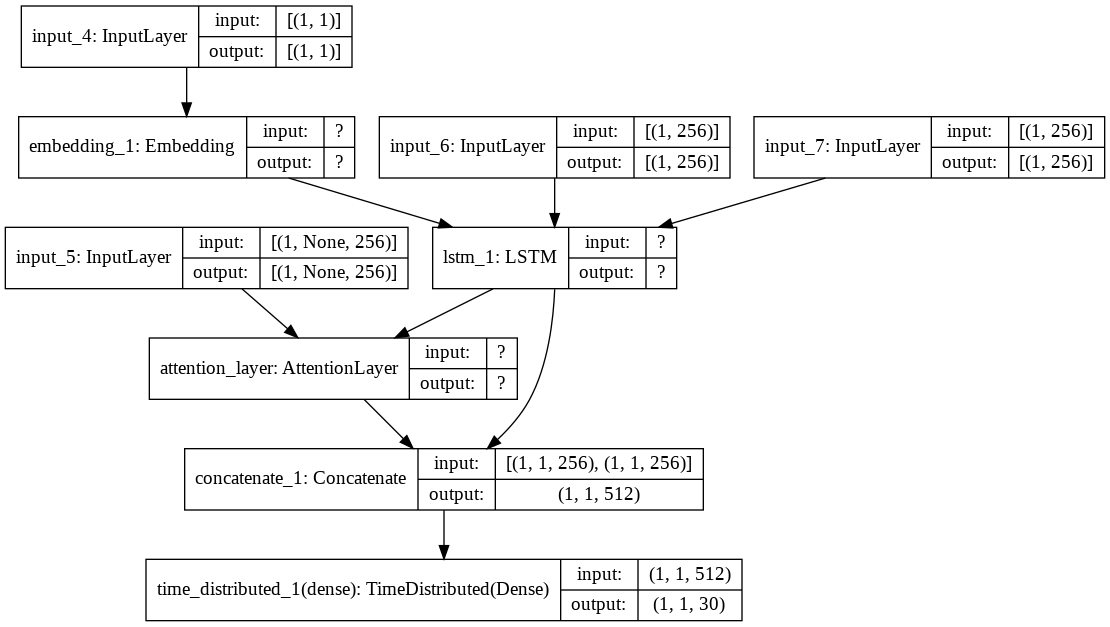

In [ ]:
plot_model(m3,show_shapes=True)

In [ ]:
data_dict

{'in_size': 72,
 'max_source_length': 20,
 'max_target_length': 23,
 'out_size': 30,
 'test': {'batch': <generator object data_loader._generate_batch at 0x7fab1d506b50>,
  'batch1': <generator object data_loader._generate_batch_greedy at 0x7faa3c8cecd0>,
  'batch_greedy': <generator object data_loader._generate_batch_greedy at 0x7faa3c8cedd0>,
  'df':           input       output
  0        अँडरसन     anderson
  1         अंकुर        ankur
  2       अंकुरित      ankurit
  3         अंगाई        angai
  4       अंगारकी      angarki
  ...         ...          ...
  5367        हॉफ         half
  5368     होऊंगा       hounga
  5369   होल्डिंग      holding
  5370  होशंगाबाद  hoshangabad
  5371    होस्टेस      hostess
  
  [4967 rows x 2 columns],
  'max_source_length': 17,
  'max_target_length': 23},
 'tokenizer': <__main__.Tokenizer at 0x7faa3ddda190>,
 'train': {'batch': <generator object data_loader._generate_batch at 0x7fab2e8b9950>,
  'batch_greedy': <generator object data_loader._ge

In [ ]:
batch_size=32
epochs=10
val_samples = 4981
train_samples = 45444
m1.fit_generator(generator = data_dict['train']['batch'],
                                            steps_per_epoch=train_samples//batch_size,
                                            epochs=epochs,
                                           validation_data=data_dict['val']['batch'],
                    validation_steps=val_samples//batch_size
                                            )

Epoch 1/10
   3/1420 [..............................] - ETA: 1:04 - loss: 0.4474 - acc: 0.2656

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1420/1420 [==============================] - 71s 50ms/step - loss: 0.2551 - acc: 0.3177 - val_loss: 0.1714 - val_acc: 0.3181
Epoch 2/10
1420/1420 [==============================] - 72s 50ms/step - loss: 0.1171 - acc: 0.3578 - val_loss: 0.1113 - val_acc: 0.3340
Epoch 3/10
1420/1420 [==============================] - 70s 49ms/step - loss: 0.0859 - acc: 0.3653 - val_loss: 0.0926 - val_acc: 0.3393
Epoch 4/10
1420/1420 [==============================] - 70s 49ms/step - loss: 0.0719 - acc: 0.3688 - val_loss: 0.0845 - val_acc: 0.3419
Epoch 5/10
1420/1420 [==============================] - 70s 49ms/step - loss: 0.0628 - acc: 0.3712 - val_loss: 0.0820 - val_acc: 0.3428
Epoch 6/10
1420/1420 [==============================] - 72s 50ms/step - loss: 0.0555 - acc: 0.3732 - val_loss: 0.0798 - val_acc: 0.3434
Epoch 7/10
1420/1420 [==============================] - 72s 51ms/step - loss: 0.0492 - acc: 0.3749 - val_loss: 0.0781 - val_acc: 0.3442
Epoch 8/10
1420/1420 [==============================] - 70s

In [ ]:
acc = 0
generator = data_dict['test']['batch_1']
tk = data_dict['tokenizer']
for j in tqdm(range(4967)) :
  (a,b),c = next(generator)
  g = [[1] + list(np.argmax(c,axis=-1)[0])]
  enc_outs, enc_last_state = m2.predict(a)
  dec_state = enc_last_state
  attention_weights = []
  word = [1]
  for i in range(23):

      dec_out, attention, dec_state = m3.predict([enc_outs, dec_state, b])
      dec_ind = np.argmax(dec_out, axis=-1)

      word.append(dec_ind[0][0])
      b = dec_ind
      attention_weights.append((dec_ind, attention))
      if dec_ind[0][0] == 2 :
        break
  str1 = tk.decode(g,mode='output')
  str2 = tk.decode([word],mode='output')
  if str1 == str2 :
    acc += 1

print(acc/4967)


0.6454600362391786


# Romanized

In [ ]:
ta_rom = dict()
ta_rom['rejoined'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['rejoined_aligned_cased'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.cased_nopunct.tsv', sep='\t', header=None, error_bad_lines=False) 
ta_rom['rejoined_aligned'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.rejoined.aligned.tsv', sep='\t', header=None, error_bad_lines=False)
ta_rom['split'] = pd.read_csv('/content/dakshina_dataset_v1.0/ta/romanized/ta.romanized.split.tsv', sep='\t', header=None, error_bad_lines=False)

In [ ]:
list(ta_rom['rejoined'].iloc[0, 0])[:10]

In [ ]:
ta_rom['rejoined_aligned_cased']

In [ ]:
ta_rom['rejoined_aligned']

In [ ]:
ta_rom['split']

In [ ]:
l1 = [1,4,2,3]
l2 = [1,4,2,5]
print(np.array(l1[1:-1])==np.array(l2[1:-1]))

[ True  True]
